In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle
import yfinance as yf
import datetime 
from scipy import stats

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score

from sklearn.ensemble import RandomForestClassifier
from engineering import *

import warnings
warnings.filterwarnings('ignore')

**🔔 Important Note:**  
> 
> To ensure correct functionality, please run all notebook cells **sequentially from top to bottom**.  
> If you execute a cell near the end of the notebook without first running the earlier sections, be sure to rerun those cells to properly initialize all required variables and dependencies.
> 
> To **reproduce the exact results** presented in the thesis, **do not retrain the model**.  
> The Random Forest algorithm includes inherent randomness, which can lead to small variation in results across runs. Instead, use the **precomputed prediction files** provided:
> 
> - `model_prediction_AAPL.pkl`
> - `model_prediction_BA.pkl`
> 
> Additionally, to ensure consistency in the features used during training and testing, load the **preselected features** from:
> 
> - `selected_features_AAPL.pkl`
> - `selected_features_BA.pkl`
> 
> We also recommend using the **historical data** stored in the `Data/` folder rather than retrieving fresh data from the yfinance API.  
> The API’s output may change over time, potentially affecting reproducibility. The API-based data loading code is commented out for this reason.
> 
> However, if you wish to experiment with **new or updated data**, you may **uncomment** those lines and run them.
> 
> Similarly, the **model training code is also commented out**. If you'd like to retrain the model and explore different predictions, you can **uncomment and run** those sections.

# Downloading the Data

The function below uses the yfinance API to download historical data for a specified stock over a given time period.

In [ ]:
# def get_ticker_data(ticker, start, end):
#     stock = yf.Ticker(ticker)
#     historical_data = stock.history(start=start, end=end)
#     return historical_data

We download the historical data for Apple. Inc between the 1st of January 2000, and the 24th of February 2025.

In [ ]:
data_start_date = datetime.datetime(2000, 1, 1)
data_end_date = datetime.datetime(2025, 2, 24)

stock = "AAPL" 
#data_df = get_ticker_data(stock, data_start_date, data_end_date)
data_df = pd.read_csv(f"data/{stock}.csv")

# Data Engineering

In this section, we focus on data engineering by removing unnecessary columns and computing technical indicators as well as lagged featuresfrom historical pricing data. These indicators will be used to predict stock price movements over the next 7 trading days. 

We remove unecessary features for our study, specifically we drop the **Stock Splits** and **Dividends** columns.

In [12]:
data_df = data_df.drop(columns=['Dividends', 'Stock Splits'])

For a given set of window sizes, we use the function defined in the engineering.py file to calculate the following technical indicators: Logarithmic Returns, Rate of Change, Exponential Moving Average, Simple Moving Average, Exponential Moving Standard Deviation, Simple Moving Standard Deviation, Bollinger Bands Width, Price Relative to the S&P 500 Index, Relative Strength Index, Normalized Average True Range, Average True Range, Volume Change Weighted Average Return, Stochastic Oscillator, Smoothed Stochastic Oscillator, Directional Index, Average Directional Index, Day of the Week, On-Balance Volume, Moving Average Convergence Divergence, and Signal Line.

In [13]:
numerical_features = []
categorical_features = []

windows = [1, 4, 7, 10, 14, 20]
for window in windows:
    data_df = log_returns(data_df, window)
    numerical_features.append(f"Log Returns_t-{window}")

    data_df = rate_of_change(data_df, window)
    numerical_features.append(f"ROC_t-{window}")

windows = [4, 7, 10, 14, 20]
for window in windows:
    data_df = moving_averages(data_df, window)
    numerical_features.append(f"EMA_{window}")
    numerical_features.append(f"SMA_{window}")
    numerical_features.append(f"EMSD_{window}")
    numerical_features.append(f"SMSD_{window}")

    data_df = bollinger_bands(data_df, window)
    numerical_features.append(f"Bollinger Bands Width_{window}")

windows = [1, 4, 7, 10]
for window in windows:
    benchmark = "^GSPC"
    data_df = chnage_to_benchmark(data_df, window, benchmark)
    numerical_features.append(f"Price Relative to {benchmark}_{window}")

windows = [3, 6, 9]
for window in windows:
    data_df = rsi(data_df, window)
    numerical_features.append(f"RSI_{window}")


windows = [4, 7, 14, 21]
numerical_features.append('TR')
for window in windows:
    data_df = average_true_range(data_df, window)
    numerical_features.append(f'Normalized_ATR_{window}')
    numerical_features.append(f'ATR_{window}')

    data_df = VWAP(data_df, window)
    numerical_features.append(f"VWAP_{window}")

    data_df = stochastic_oscillator(data_df, window)
    numerical_features.append(f"Stochastic Oscillator_{window}")
    numerical_features.append(f"Smoothed Stochastic Oscillator_{window}")

    data_df = directional_index(data_df, window)
    numerical_features.append(f"DX_{window}")
    numerical_features.append(f"ADX_{window}")

data_df = day_of_week(data_df)
categorical_features.append("Weekday")

data_df = on_balance_volume(data_df)
numerical_features.append("On Balance Volume")

data_df = compute_macd(data_df)
numerical_features.append(f'MACD_6-13')
numerical_features.append(f'Signal_Line_6-13-5')

The target variable of our model is the stock price movement over the next 7 trading days. To construct the target vector, we compare the stock's closing price on the buy date with its closing price at the end of the 7th subsequent trading day. Additionally, we compute the realized returns by calculating the percentage change between each closing price and the corresponding closing price 7 trading days later. The fucntion used to do so, can be found in the engineering.py file.

In [14]:
weekly_return = movement_returns(data_df, 7)
target_vector_weekly = stock_movement(data_df, 7)

We drop non-stationary features such as Open and Volume. While Close, High, and Low are also non-stationary, we retain them at this stage for completeness, although they are not expected to be selected as important features during the model selection process.

In [15]:
data_df = data_df.drop(columns=["Open", "Volume", "Date"])
numerical_features.append("Close")
numerical_features.append("High")
numerical_features.append("Low")

To incorporate sequential information, we also add lagged features for each row based on values from a set of previous trading days.

In [16]:
lagged_periods = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 19, 26, 34]
features_to_lag = list(data_df.columns)
for p in lagged_periods:
    for feature in features_to_lag:
        if feature != "Weekday":
            data_df = lagged_feature(data_df, feature, p)       
            numerical_features.append(f"Lagged_{feature}_t-{p}") 

# Data Handling and Model Training

The dataset is split into multiple training and test sets, each containing 730 and 365 data points, respectively. Similarly, the returns and target variables are partitioned in the same manner. In the end, each sub-dataset consists of a training set, its corresponding target vector, the associated returns, and a test set. Furthermore, for each sub-dataset we encode the categorical variables.

In [17]:
def sliding_window_split(data, y_data, sequence_size, text_length, returns):

    X_train_sets = []
    y_train_sets = []
    X_test_sets = []
    y_test_sets = []
    returns_sets = []
    train_returns_sets = []
    start = 0

    while start + sequence_size + text_length <= len(data):
        train_end = start + sequence_size
        test_end = train_end + text_length

        X_train_data = data.iloc[start:train_end] if isinstance(data, pd.DataFrame) else data[start:train_end]
        X_test_data = data.iloc[train_end:test_end] if isinstance(data, pd.DataFrame) else data[train_end:test_end]
        train_returns = returns.iloc[start:train_end] if isinstance(data, pd.DataFrame) else data[train_end:test_end]

        y_train_data = y_data.iloc[start:train_end] if isinstance(data, pd.DataFrame) else y_data[start:train_end]
        y_test_data = y_data.iloc[train_end:test_end] if isinstance(data, pd.DataFrame) else y_data[train_end:test_end]
        return_data = returns.iloc[train_end:test_end] if isinstance(data, pd.DataFrame) else returns[train_end:test_end]

        X_train_sets.append(X_train_data)
        X_test_sets.append(X_test_data)

        y_train_sets.append(y_train_data)
        y_test_sets.append(y_test_data)
        returns_sets.append(return_data)
        train_returns_sets.append(train_returns)

        start += text_length

    return X_train_sets, X_test_sets, y_train_sets, y_test_sets, returns_sets, train_returns_sets

In [18]:
X_train_sets, X_test_sets, y_train_sets, y_test_sets, daily_returns_set, train_returns = sliding_window_split(data_df, target_vector_weekly, 730, 365, weekly_return)

for i in range(len(X_train_sets)):
    encoder = OneHotEncoder(sparse_output=False, drop='first')  # Avoid dummy variable trap

    encoded_categorical = encoder.fit_transform(X_train_sets[i][categorical_features])
    encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_features))
    X_train_sets[i] = X_train_sets[i].drop(columns=["Weekday"])

    cat_feature_names = encoder.get_feature_names_out(categorical_features)
    feature_columns = numerical_features + list(cat_feature_names)
    
    X_train_sets[i] = np.hstack((X_train_sets[i], encoded_categorical_df))
    X_train_sets[i] = pd.DataFrame(X_train_sets[i], columns=feature_columns)
    
    test_encoded = encoder.transform(X_test_sets[i][categorical_features])
    test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(categorical_features))
    X_test_sets[i] = X_test_sets[i].drop(columns=["Weekday"])

    X_test_sets[i] = np.hstack((X_test_sets[i], test_encoded_df))
    X_test_sets[i] = pd.DataFrame(X_test_sets[i], columns=feature_columns)

Before training across all sub-datasets, we use the first training set to fit a Random Forest model and perform feature selection. Only the features with an importance score greater than or equal to 0.001 are retained. These selected features are then used for training and testing on all subsequent sub-datasets.

In [ ]:
# rf_model = RandomForestClassifier(
#         n_estimators=2637,  # Number of trees
#         max_depth=26,    # Maximum depth of each tree
#         min_samples_split=31,  # Minimum samples required to split a node
#         min_samples_leaf=2,
#         max_features='sqrt'   # Minimum samples required at a leaf node
#     )
# rf_model.fit(X_train_sets[0], y_train_sets[0])

RandomForestClassifier(max_depth=26, min_samples_leaf=2, min_samples_split=31,
                       n_estimators=2637)

In [ ]:
# feature_importance = pd.Series()
# importance = rf_model_2.feature_importances_
# features = list(X_train_sets[0].columns)

# for i in range(len(features)):
#     feature_importance[features[i]] = importance[i]

# feature_importance.sort_values(ascending=False, inplace=True)
# selected_features = list(feature_importance[feature_importance >= 0.001].index)

In [ ]:
# with open(f"selected_features_{stock}.pkl", "wb") as file:
#     pickle.dump(selected_features, file)

In [19]:
with open(f"selected_features_{stock}.pkl", "rb") as file:
    selected_features = pickle.load(file)

For each sub-dataset, we train five Random Forest models on the training set. Each model is then used to generate predictions on the corresponding test set. The final prediction is computed as the average of the five model predictions. It represents the estimated probability of an upward price movement over the subsequent 7 trading days. The resulting list is composed by the predictions on each sub-dataset.

In [ ]:
# models_predictions = []
# for z in range(len(X_train_sets)):
#     ensemble_models = []

#     for i in range(5):
#         rf_model = RandomForestClassifier(
#             n_estimators=2763,  # Number of trees
#             max_depth=7,    # Maximum depth of each tree
#             min_samples_split=19,  # Minimum samples required to split a node
#             min_samples_leaf=8,
#             max_features='sqrt'  # Minimum samples required at a leaf node
#         )
#         rf_model.fit(X_train_sets[z][selected_features], y_train_sets[z])

#         y_pred_prob = rf_model.predict_proba(X_test_sets[z][selected_features])
#         positive_prob = np.array([y_pred_prob[i][1] for i in range(len(y_pred_prob))])
#         ensemble_models.append(positive_prob)

#     models_predictions.append(ensemble_models)

We save the prediction list in a pickle file.

In [ ]:
# Save the models_predictions list to a file
# with open("models_predictions.pkl", "wb") as file:
#     pickle.dump(models_predictions, file)

We use the model predictions saved in the `selected_features_stock.pkl` file.

In [20]:
with open(f"models_predictions_{stock}.pkl", "rb") as file:
    models_predictions = pickle.load(file)

# For each sub-dataset, we average the prediction over all the random forest models trained for the corresponding training set
for i in range(len(models_predictions)):
    ensemble_predictions = np.mean(models_predictions[i], axis=0)
    models_predictions[i] = ensemble_predictions

# Game Simulation

This section leverages the predictions from each sub-test set to simulate a betting game based on the model's forecasted probabilities.

## Estimating the Minimum Required Precision

For each sub-training set, we estimate the minimum required precision needed to achieve a favorable betting scenario, using the estimated positive and negative returns recorded up to that point, that is, across all training and testing data preceding the given sub-dataset.

In [21]:
# The following code organizes the positive and negative returns accumulated up to a given sub-dataset
list_positive_returns = []
list_negative_returns =  []

for z in range(len(y_test_sets)):
    if z == 0:
        past_returns = weekly_return[:y_train_sets[z].index[-1]]
        pos_returns = past_returns[target_vector_weekly[:y_train_sets[z].index[-1]][target_vector_weekly == 1].index]
        neg_returns = past_returns[target_vector_weekly[:y_train_sets[z].index[-1]][target_vector_weekly == 0].index]
        list_positive_returns.append(pos_returns)
        list_negative_returns.append(neg_returns)
    else:
        past_returns = weekly_return[:y_test_sets[z - 1].index[-1]]
        
        pos_returns = past_returns[target_vector_weekly[:y_test_sets[z - 1].index[-1]][target_vector_weekly == 1].index]
        neg_returns = past_returns[target_vector_weekly[:y_test_sets[z - 1].index[-1]][target_vector_weekly == 0].index]
        
        list_positive_returns.append(pos_returns)
        list_negative_returns.append(neg_returns)

For each sub-dataset, we compute the expected positive and negative returns, along with their respective standard deviations.

In [22]:
array_expected_pos_returns = []
array_std_pos_returns = []
array_expected_neg_returns = []
array_std_neg_returns = []

for i in range(len(list_positive_returns)):
    # mean and standard deviation of positive returns 
    pos_mu, pos_sigma = stats.norm.fit(list_positive_returns[i])
    array_expected_pos_returns.append(pos_mu)
    array_std_pos_returns.append(pos_sigma)

    # mean and standard deviation of negative returns 
    neg_mu, neg_sigma = stats.norm.fit(list_negative_returns[i])
    array_expected_neg_returns.append(neg_mu)
    array_std_neg_returns.append(neg_sigma)

For each sub-dataset, We compute the **minimum precision thresholds** using the respective estimated positive and negative returns using the formula $$p_{min} = \frac{-\mathbb{E}[Z]}{\mathbb{E}[V] - \mathbb{E}[Z]}$$
where $V$ and $Z$ are random variables representing the positive and negative returns, respectively.

In [23]:
min_precision_thresholds = []
for i in range(len(list_positive_returns)):
    threshold = (- array_expected_neg_returns[i] / (array_expected_pos_returns[i] - array_expected_neg_returns[i]))
    min_precision_thresholds.append(threshold)

mim_precision_thresholds = np.array(min_precision_thresholds)

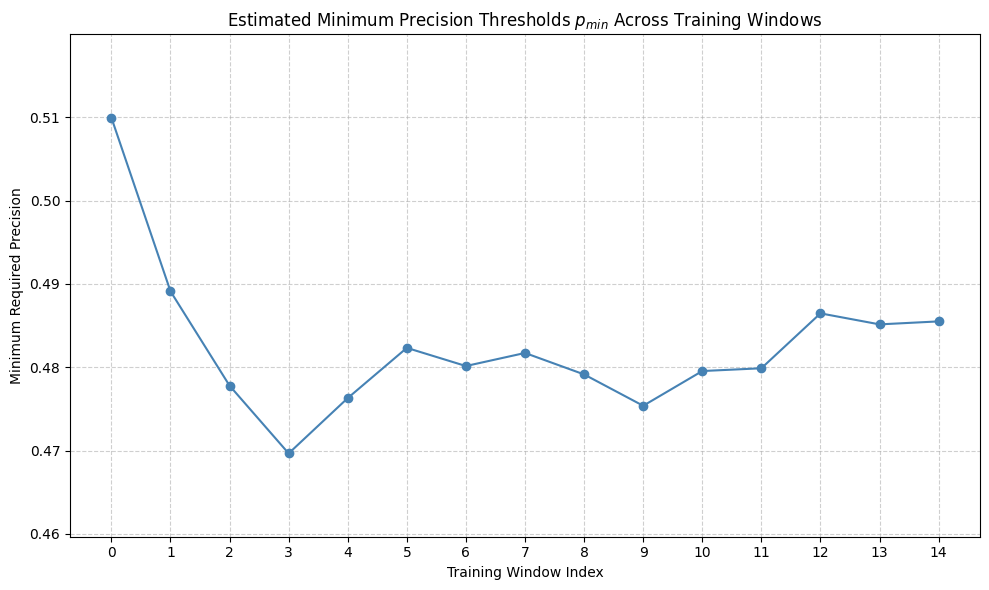

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(mim_precision_thresholds, marker='o', linestyle='-', color='steelblue')
plt.title('Estimated Minimum Precision Thresholds $p_{min}$ Across Training Windows')
plt.xlabel('Training Window Index')
plt.ylabel('Minimum Required Precision')
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(range(len(mim_precision_thresholds))) 
plt.ylim(min(mim_precision_thresholds) - 0.01, max(mim_precision_thresholds) + 0.01)
plt.tight_layout()
plt.show()

## Threshold Tuning via Validation

Since our model outputs probabilities, it is essential to define a decision threshold: if the predicted probability of an upward movement exceeds this threshold, we classify it as a positive prediction. To determine this threshold, we aim to maximize precision on a validation set.

Each sub-test set is further divided into multiple overlapping validation and test windows. A validation window consists of 10 consecutive trading days and is rolled forward one day at a time. For each validation window, the corresponding test point is set 7 trading days after the end of the window, aligning with the model’s prediction horizon and ensuring no look-ahead bias.

To avoid overly conservative thresholds that may result in too few positive predictions, we impose a constraint: at least 70% of predictions in the validation window must be positive. Among the thresholds satisfying this constraint, we select the one that yields the highest precision. This selected threshold is then used to evaluate the model's prediction on the associated test point.

In [25]:
list_validation_sets = []
list_test_sets = []
list_y_test = []
list_y_validation = []
list_test_returns = []
list_val_returns = []

max_val_size = 10
prediction_horizon = 7
for i in range(len(models_predictions)):
    test_size = 1
    start_validation_size = 10
    validation_sets = []
    test_sets = []
    val_return_sets = []
    test_return_sets = []
    y_true_test = []
    y_true_val = []
    
    while start_validation_size + prediction_horizon < 365:
        if 365 - start_validation_size < test_size:
            test_size = 365 - start_validation_size
        
        low_bound = start_validation_size - max_val_size * int(start_validation_size >= max_val_size)
        
        validation_sets.append(models_predictions[i][low_bound : start_validation_size])
        y_true_val.append(y_test_sets[i][low_bound : start_validation_size])
        val_return_sets.append(daily_returns_set[i][low_bound: start_validation_size])

        test_sets.append(models_predictions[i][start_validation_size + prediction_horizon : start_validation_size + test_size + prediction_horizon])
        y_true_test.append(y_test_sets[i][start_validation_size + prediction_horizon : start_validation_size + test_size + prediction_horizon])
        test_return_sets.append(daily_returns_set[i].values[start_validation_size + prediction_horizon : start_validation_size + test_size + prediction_horizon])

       
        start_validation_size += test_size
        
    
    list_validation_sets.append(validation_sets)
    list_test_sets.append(test_sets)
    list_y_test.append(y_true_test)
    list_y_validation.append(y_true_val)
    list_test_returns.append(test_return_sets)
    list_val_returns.append(val_return_sets)

For each validation set, we evaluate all possible thresholds within the interval $[0,1]$ and select the one that maximizes precision on the validation set.

In [26]:
list_best_thresholds = []
list_best_precisions = []
list_num_predictions = []
for i in range(len(list_validation_sets)):
    best_thresholds = []
    best_precisions = []
    best_num_positives = []

    for j in range(len(list_validation_sets[i])):
        precisions = [None for i in range(101)]
        positives_predicted = [None for i in range(101)]
        for p in range(101):
            y_preds = (list_validation_sets[i][j] > p/100).astype("int32")
            positives = len(y_preds[y_preds == 1])
            precision = precision_score(list_y_validation[i][j], y_preds)
            precisions[p] = precision
            positives_predicted[p] = positives
        
        maximum_precision = 0
        corresponding_pos = 0
        index = 0
        for p in range(101):
            if precisions[p] > maximum_precision and positives_predicted[p] >= len(list_validation_sets[i][j]) * (70/100):
                maximum_precision = precisions[p]
                corresponding_pos = positives_predicted[p]
                index = p

        best_thresholds.append(index)
        best_precisions.append(maximum_precision)
        best_num_positives.append(corresponding_pos)
    
    list_best_thresholds.append(best_thresholds)
    list_best_precisions.append(best_precisions)
    list_num_predictions.append(best_num_positives)

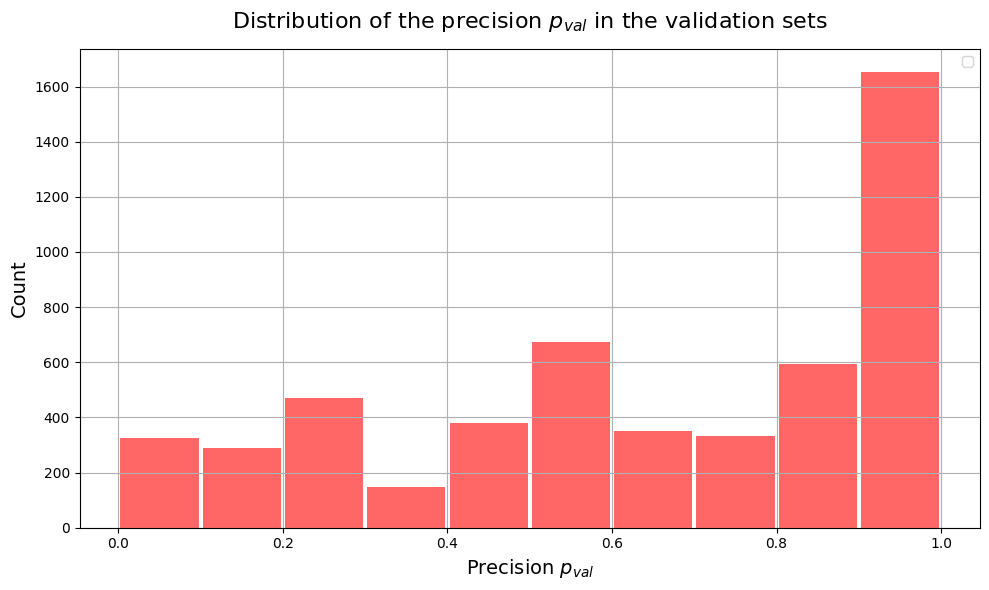

In [27]:
precisions = []

for i in range(len(list_best_precisions)):
    for j in range(len(list_best_precisions[i])):
        precisions.append(list_best_precisions[i][j])
plt.figure(figsize=(10, 6))
plt.hist(precisions, alpha=0.6, color='red', bins=10, rwidth=0.95)
plt.title('Distribution of the precision $p_{val}$ in the validation sets', fontsize=16, pad=15)
plt.xlabel('Precision $p_{val}$', fontsize=14)
plt.legend()
plt.ylabel('Count', fontsize=14)
plt.grid(True)
plt.tight_layout()

plt.show()

The tuned threshold from each validation set is then used to classify the stock movement based on the model’s predicted probability for the corresponding test point, with one test point defined per validation window.

In [28]:
list_test_pred = []
for i in range(len(list_test_sets)):
    years_preds = []
    for j in range(len(list_test_sets[i])):
        y_preds = (list_test_sets[i][j] > list_best_thresholds[i][j]/100).astype("int32")
        years_preds.append(y_preds)
    list_test_pred.append(years_preds)

## The Kelly optimal fractions

We begin by estimating the expected return of a bet at a given test point, using the precision obtained from its corresponding validation window. $$\mathbb{E}[X] = p_{val}\cdot\mathbb{E}[V] + ( 1 - p_{val})\cdot\mathbb{E}[Z]$$

In [29]:
expectations_Xi = []

for i in range(len(list_test_pred)):
    window_expectations_Xi = []
    for j in range(len(list_test_pred[i])):
        expectation_Xi =  array_expected_pos_returns[i] * list_best_precisions[i][j] + array_expected_neg_returns[i] * (1 - list_best_precisions[i][j])
        window_expectations_Xi.append(expectation_Xi)
    expectations_Xi.append(window_expectations_Xi)

expectations_Xi = np.array(expectations_Xi)

Similarly to the estimation of the expected positive and negative returns $\mathbb{E}[V]$ and $\mathbb{E}[Z]$, we estimate the squarred positive and negative returns $\mathbb{E}[V^2]$ and $\mathbb{E}[Z^2]$, respectively.

In [30]:
sq_pos_mus = []
sq_neg_mus = []
sq_pos_sigmas = []
sq_neg_sigmas = []
for i in range(len(min_precision_thresholds)):
    sq_positive_daily_returns = list_positive_returns[i] ** 2
    sq_negative_daily_returns = list_negative_returns[i] ** 2

    # meand and standard deviation of the squarred positive returns 
    sq_pos_mu, sq_pos_sigma = stats.norm.fit(sq_positive_daily_returns)
    sq_pos_mus.append(sq_pos_mu)
    sq_pos_sigmas.append(sq_pos_sigma)

    # meand and standard deviation of the squarred positive returns 
    sq_neg_mu, sq_neg_sigma = stats.norm.fit(sq_negative_daily_returns)
    sq_neg_mus.append(sq_neg_mu)
    sq_neg_sigmas.append(sq_neg_sigma)

We compute the Kelly Optimal fraction using the following formula $$f^* =\frac{\mathbb{E}[X]}{\mathbb{E}[X^2]}$$

In [31]:
optimal_fractions = []
for i in range(len(list_test_pred)):
    window_optimal_fractions = []
    for j in range(len(list_test_pred[i])):
        optimal_fraction = expectations_Xi[i][j] / (list_best_precisions[i][j] * sq_pos_mus[i] + (1 - list_best_precisions[i][j]) * sq_neg_mus[i])
        window_optimal_fractions.append(optimal_fraction)
    optimal_fractions.append(window_optimal_fractions)

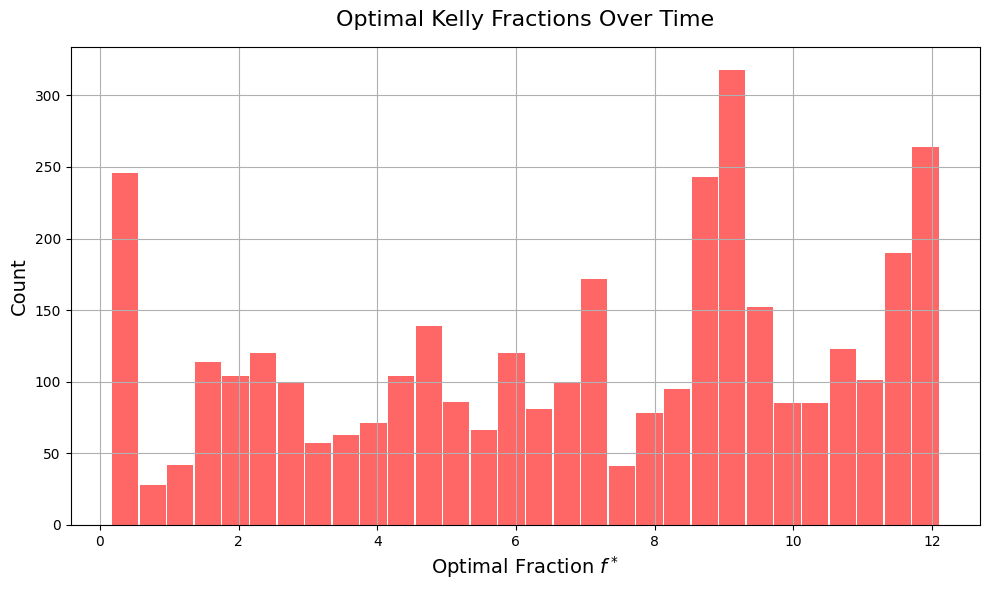

In [32]:
to_plot = []
for i in range(len(list_best_precisions)):
    for j in range(len(list_best_precisions[i])):
        if list_best_precisions[i][j] > min_precision_thresholds[i]:
            to_plot.append(optimal_fractions[i][j])

fraction_series = pd.Series(to_plot)

plt.figure(figsize=(10, 6))
plt.hist(fraction_series, alpha=0.6, label='Raw $f^*$', color='red', bins=30, rwidth=0.95)
plt.title('Optimal Kelly Fractions Over Time', fontsize=16, pad=15)
plt.xlabel('Optimal Fraction $f^*$', fontsize=14)
plt.grid(True)
plt.ylabel('Count', fontsize=14)
plt.tight_layout()
plt.show()

## Game Simulation on the Testing Points

### Precision-guided Kelly Strategy (No Leverage)

We initiate the simulation with a total capital of $7,000, divided into 7 separate sub-capitals of $1,000 each. This setup allows us to place one trade per trading day, considering that each trade requires a 7-day holding period before its capital becomes available again.

For every test point, we begin by checking whether the estimated validation precision exceeds the minimum required precision threshold: $$p_{val} > p_{min}$$ If this condition is not met, we treat the test point as a non-trading opportunity and simply carry forward the current values of all sub-capitals unchanged. 

If the condition is met, we consider the test point for a potential trade. We then examine the model's prediction using the corresponding tuned threshold. If the prediction indicates a positive movement (i.e., an upward price move), we place a bet. The corresponding sub-capital (rotated using a tracker to ensure proper cycling over the 7-day structure) is updated based on the realized return at that test point. The return is scaled by an optimal fraction $f^*$ that corresponds to this testing point, and which is capped at 1 to avoid overexposure.

If the actual return is positive, the sub-capital is increased proportionally. If the return is negative or zero, the sub-capital is reduced accordingly. If the prediction indicates a downward movement, no trade is executed, and the sub-capital remains unchanged. In either case, all other sub-capitals are updated by carrying forward their previous values. This process simulates a realistic trading mechanism with proper capital allocation and delay between investment and return realization. At the end of the simulation, we aggregate all sub-capitals over time to compute the evolution of the total weekly capital.

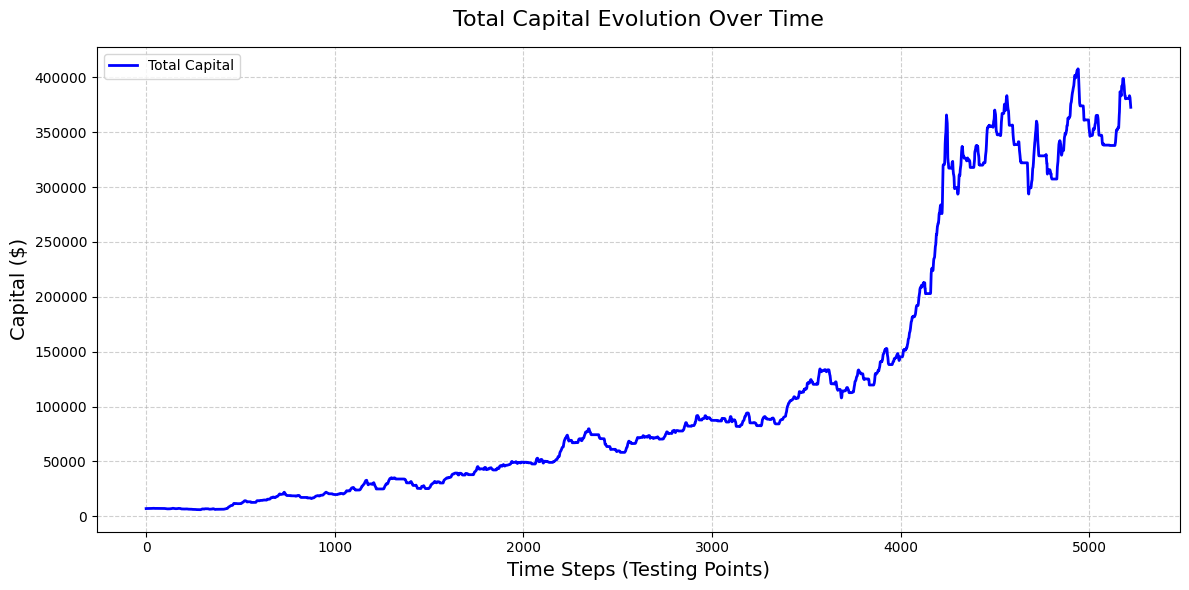

In [33]:
number_of_trades = 0
initial_capitals = [1000 for i in range(7)]
capital_evolutions = [[1000] for i in range(7)]
movement_pred = list_test_pred
returns = list_test_returns
tracker = 0

for i in range(len(movement_pred)):
    for j in range(len(movement_pred[i])):
        if list_best_precisions[i][j] > min_precision_thresholds[i]:
            if optimal_fractions[i][j] > 1:
                f = 1
            else:
                f = optimal_fractions[i][j]
            corresponding_returns = list(returns[i][j])

            for z in range(len(movement_pred[i][j])):
                if movement_pred[i][j][z] == 1:
                    number_of_trades += 1
                    
                    initial_capitals[tracker % 7] += (initial_capitals[tracker % 7] * f) * corresponding_returns[z] 
                    capital_evolutions[tracker  % 7].append(initial_capitals[tracker  % 7])
                    
                else:
                    capital_evolutions[tracker  % 7].append(initial_capitals[tracker  % 7])
                
                for k in range(len(capital_evolutions)):
                    if k != tracker % 7:
                        capital_evolutions[k].append(initial_capitals[k])
                tracker += 1
        else:
            for v in range(len(capital_evolutions)):
                capital_evolutions[v].append(initial_capitals[v])

for i in range(len(capital_evolutions)): 
    capital_evolutions[i] = np.array(capital_evolutions[i])
capital_evolutions = np.array(capital_evolutions)

weekly_capital = np.sum(capital_evolutions, axis=0)

plt.figure(figsize=(12, 6))
plt.plot(weekly_capital, label='Total Capital', color='blue', linewidth=2)
plt.title('Total Capital Evolution Over Time', fontsize=16, pad=15)
plt.xlabel('Time Steps (Testing Points)', fontsize=14)
plt.ylabel('Capital ($)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

In [34]:
capital = weekly_capital
initial_capital = capital[0]

cumulative_return = (capital[-1] - initial_capital) / initial_capital

log_returns = np.diff(np.log(capital))
mean_log_return = np.mean(log_returns)
volatility = np.std(log_returns)
annualized_volatility = volatility * np.sqrt(52)

running_max = np.maximum.accumulate(capital)
drawdowns = (capital - running_max) / running_max
max_drawdown = np.min(drawdowns)

sharpe_ratio = mean_log_return / volatility

final_capital = capital[-1]

print(f"Final Capital: ${final_capital:.2f}")
print(f"Cumulative Return: {cumulative_return:.2%}")
print(f"Mean Log Return: {mean_log_return:.4f}")
print(f"Volatility: {volatility:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Total Trades: {number_of_trades}")

Final Capital: $372653.33
Cumulative Return: 5223.62%
Mean Log Return: 0.0008
Volatility: 0.0057
Sharpe Ratio: 0.13
Max Drawdown: -28.23%
Total Trades: 3147


### Precision-guided Strategy using Leverage (Capped at 2)

We use the same procedure previously decribed. However, in this case we allow for the fraction to be greater than 1 (caped at 2), representing leveraging. In each trade we first borrow $f-1$ and then after recording the return we pay back the loan and update the sub-capital that corresponds with the trade.

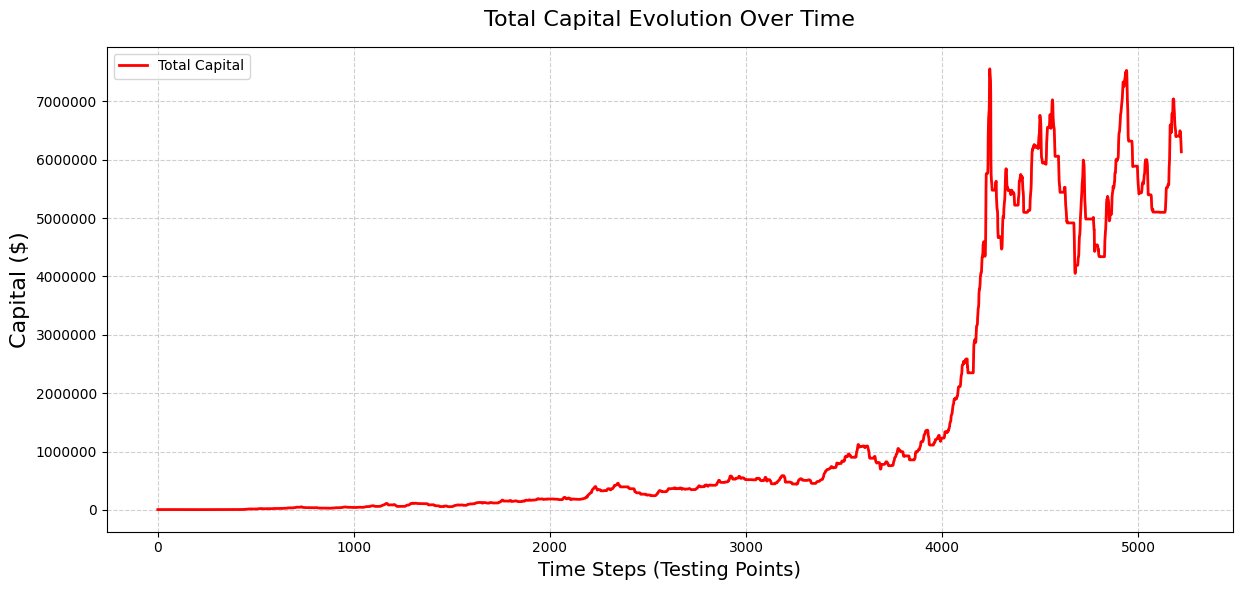

In [36]:
number_of_trades = 0
initial_capitals = [1000 for i in range(7)]
capital_evolutions = [[1000] for i in range(7)]
movement_pred = list_test_pred
returns = list_test_returns
tracker = 0
interest_cost = 0 
for i in range(len(movement_pred)):
    for j in range(len(movement_pred[i])):
        if list_best_precisions[i][j] > min_precision_thresholds[i]:
            f = optimal_fractions[i][j]
            corresponding_returns = list(returns[i][j])

            for z in range(len(movement_pred[i][j])):
                idx = tracker % 7
                current_capital = initial_capitals[idx]
                
                if movement_pred[i][j][z] == 1:
                    number_of_trades += 1
                    if f > 2:
                        invested_capital = current_capital * 2
                        not_invested = 0
                        loan_repayment = current_capital * (2 - 1)
                    elif f > 1 and f <= 2:
                        invested_capital = current_capital * f
                        not_invested = 0
                        loan_repayment = current_capital * (f - 1)
                    else:
                        invested_capital = current_capital * f
                        not_invested = current_capital - invested_capital
                        loan_repayment = 0

                    initial_capitals[idx] = not_invested + (invested_capital * (1 + corresponding_returns[z])) - (loan_repayment * (1 + (interest_cost/100)))
                    if initial_capitals[idx] == 0:
                        print(True)
                    capital_evolutions[idx].append(initial_capitals[idx])
                    
                else:
                    capital_evolutions[idx].append(current_capital)
                    
                for k in range(len(capital_evolutions)):
                    if k != idx:
                        capital_evolutions[k].append(initial_capitals[k])
                tracker += 1
        else:
            for v in range(len(capital_evolutions)):
                capital_evolutions[v].append(initial_capitals[v])
    
for i in range(len(capital_evolutions)): 
    capital_evolutions[i] = np.array(capital_evolutions[i])
capital_evolutions = np.array(capital_evolutions)

weekly_capital_leverage = np.sum(capital_evolutions, axis=0)

plt.figure(figsize=(12, 6))
plt.plot(weekly_capital_leverage, label='Total Capital', color='red',linewidth=2)
plt.title('Total Capital Evolution Over Time', fontsize=16, pad=15)
plt.xlabel('Time Steps (Testing Points)', fontsize=14)
plt.ylabel('Capital ($)', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [37]:
capital = weekly_capital_leverage
initial_capital = capital[0]

cumulative_return = (capital[-1] - initial_capital) / initial_capital

log_returns = np.diff(np.log(capital))
mean_log_return = np.mean(log_returns)
volatility = np.std(log_returns)
annualized_volatility = volatility * np.sqrt(52)

running_max = np.maximum.accumulate(capital)
drawdowns = (capital - running_max) / running_max
max_drawdown = np.min(drawdowns)

sharpe_ratio = mean_log_return / volatility

final_capital = capital[-1]

print(f"Final Capital: ${final_capital:.2f}")
print(f"Cumulative Return: {cumulative_return:.2%}")
print(f"Mean Log Return: {mean_log_return:.4f}")
print(f"Volatility: {volatility:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Total Trades: {number_of_trades}")

Final Capital: $6135507.73
Cumulative Return: 87550.11%
Mean Log Return: 0.0013
Volatility: 0.0121
Sharpe Ratio: 0.11
Max Drawdown: -52.07%
Total Trades: 3147


### Difference between Leverage with and without Interest Costs

In this section, we compare two versions of the precision-guided trading strategy: one that applies leverage without accounting for interest costs, and another that incorporates an interest cost of 0.014% per trade. This rate is derived from an annualized interest of 0.5% applied to each borrowed amount.

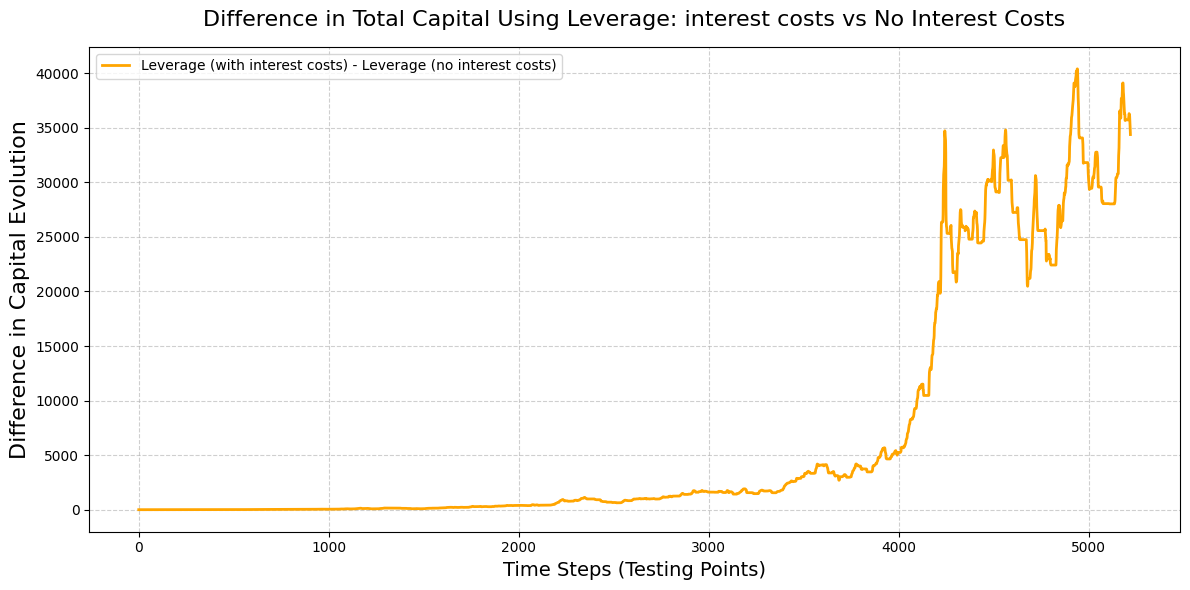

In [38]:
number_of_trades = 0
initial_capitals = [1000 for i in range(7)]
capital_evolutions = [[1000] for i in range(7)]
movement_pred = list_test_pred
returns = list_test_returns
tracker = 0
interest_cost = 0.0014 
for i in range(len(movement_pred)):
    for j in range(len(movement_pred[i])):
        if list_best_precisions[i][j] > min_precision_thresholds[i]:
            f = optimal_fractions[i][j]
            corresponding_returns = list(returns[i][j])

            for z in range(len(movement_pred[i][j])):
                idx = tracker % 7
                current_capital = initial_capitals[idx]
                
                if movement_pred[i][j][z] == 1:
                    number_of_trades += 1
                    if f > 2:
                        invested_capital = current_capital * 2
                        not_invested = 0
                        loan_repayment = current_capital * (2 - 1)
                    elif f > 1 and f <= 2:
                        invested_capital = current_capital * f
                        not_invested = 0
                        loan_repayment = current_capital * (f - 1)
                    else:
                        invested_capital = current_capital * f
                        not_invested = current_capital - invested_capital
                        loan_repayment = 0

                    initial_capitals[idx] = not_invested + (invested_capital * (1 + corresponding_returns[z])) - (loan_repayment * (1 + (interest_cost/100)))
                    if initial_capitals[idx] == 0:
                        print(True)
                    capital_evolutions[idx].append(initial_capitals[idx])
                    
                else:
                    capital_evolutions[idx].append(current_capital)
                    
                for k in range(len(capital_evolutions)):
                    if k != idx:
                        capital_evolutions[k].append(initial_capitals[k])
                tracker += 1
        else:
            for v in range(len(capital_evolutions)):
                capital_evolutions[v].append(initial_capitals[v])
    
for i in range(len(capital_evolutions)): 
    capital_evolutions[i] = np.array(capital_evolutions[i])
capital_evolutions = np.array(capital_evolutions)

weekly_capital_leverage_int = np.sum(capital_evolutions, axis=0)

plt.figure(figsize=(12, 6))
plt.plot(weekly_capital_leverage - weekly_capital_leverage_int, label='Leverage (with interest costs) - Leverage (no interest costs)', color='orange', linewidth=2)
plt.title('Difference in Total Capital Using Leverage: interest costs vs No Interest Costs', fontsize=16, pad=15)
plt.xlabel('Time Steps (Testing Points)', fontsize=14)
plt.ylabel('Difference in Capital Evolution', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.ticklabel_format(style='plain', axis='y')
plt.show()

### Precision-Guided Kelly Strategy vs Random Prediction Strategy

In this section, we compare the precision-guided Kelly strategy without leverage to a baseline strategy that generates predictions randomly, based on the observed proportion of upward and downward movements in the training sets. In the random strategy, whenever an upward movement is predicted, the entire capital is placed on the trade.

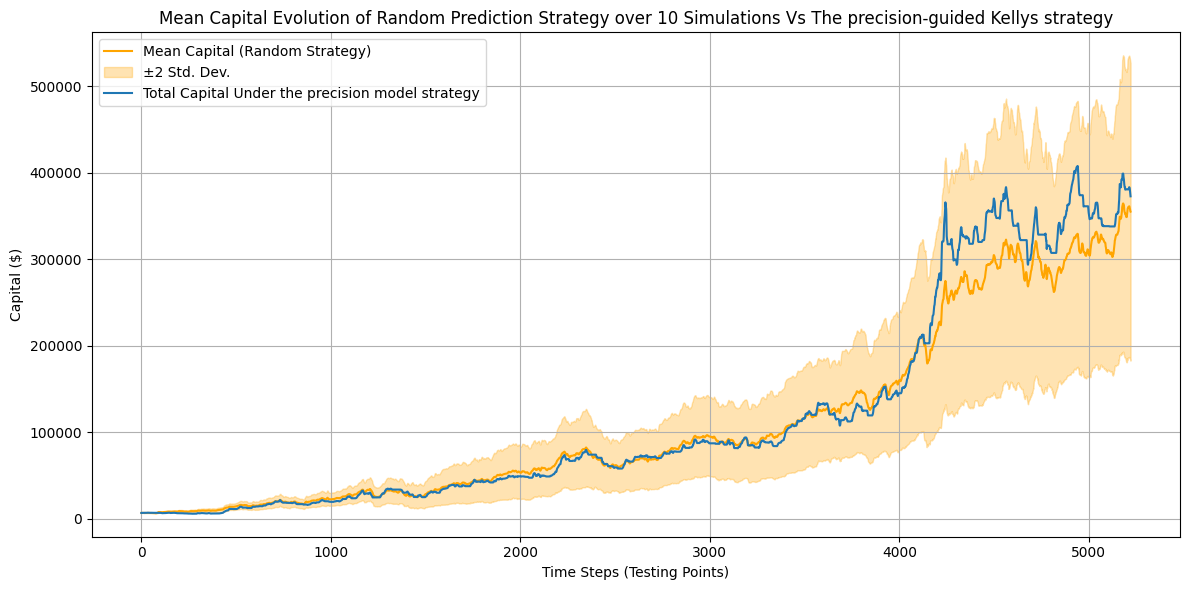

In [39]:
list_num_postives = []
for i in range(len(y_train_sets)):
    list_num_postives.append(np.sum(y_train_sets[i])/len(y_train_sets[i]))

num_repeats = 10
all_capitals = []
list_num_trades = []
for repeat in range(num_repeats):
    random.seed(7 + repeat)  
    initial_capitals = [1000 for _ in range(7)]
    capital_evolutions = [[1000] for _ in range(7)]
    tracker = 0
    number_of_trades = 0
    for i in range(len(movement_pred)):
        for j in range(len(movement_pred[i])):
            corresponding_returns = list(returns[i][j])

            for z in range(len(movement_pred[i][j])):
                pred = random.choices([1, 0], weights=[list_num_postives[i], 1 - list_num_postives[i]])[0]
                idx = tracker % 7
                if pred == 1:
                    number_of_trades +=1
                    capital_gain = initial_capitals[idx] * corresponding_returns[z] 
                    initial_capitals[idx] += capital_gain
                capital_evolutions[idx].append(initial_capitals[idx])

                for v in range(len(capital_evolutions)):
                    if tracker % 7 != v:
                        capital_evolutions[v].append(initial_capitals[v])
                tracker += 1
    list_num_trades.append(number_of_trades)

    capital_evolutions = np.array([np.array(c) for c in capital_evolutions])
    total_capital = np.sum(capital_evolutions, axis=0)
    all_capitals.append(total_capital)

all_capitals = np.array(all_capitals)

mean_capital = np.mean(all_capitals, axis=0)
std_capital = np.std(all_capitals, axis=0)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(mean_capital, label='Mean Capital (Random Strategy)', color='orange')
plt.fill_between(range(len(mean_capital)), 
                 mean_capital - 2*std_capital, 
                 mean_capital + 2*std_capital, 
                 color='orange', alpha=0.3, label='±2 Std. Dev.')
plt.plot(weekly_capital, label='Total Capital Under the precision model strategy')
plt.title('Mean Capital Evolution of Random Prediction Strategy over 10 Simulations Vs The precision-guided Kellys strategy')
plt.xlabel('Time Steps (Testing Points)')
plt.ylabel('Capital ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
capital = mean_capital
initial_capital = capital[0]

cumulative_return = (capital[-1] - initial_capital) / initial_capital

log_returns = np.diff(np.log(capital))
mean_log_return = np.mean(log_returns)
volatility = np.std(log_returns)
annualized_volatility = volatility * np.sqrt(52)

running_max = np.maximum.accumulate(capital)
drawdowns = (capital - running_max) / running_max
max_drawdown = np.min(drawdowns)

sharpe_ratio = mean_log_return / volatility

final_capital = capital[-1]

print(f"Final Capital: ${final_capital:.2f}")
print(f"Cumulative Return: {cumulative_return:.2%}")
print(f"Mean Log Return: {mean_log_return:.4f}")
print(f"Volatility: {volatility:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Total Trades: {number_of_trades}")

Final Capital: $354946.44
Cumulative Return: 4970.66%
Mean Log Return: 0.0008
Volatility: 0.0047
Sharpe Ratio: 0.16
Max Drawdown: -28.68%
Total Trades: 2997


### Precision-Guided Kelly Strategy (with Leverage) vs Buy-and-Hold Strategy

In this section, we compare the precision-guided Kelly strategy with leverage (capped at 2) to a simple Buy-and-Hold strategy. In the Buy-and-Hold approach, the entire capital is invested at the start of the simulation, and the capital's evolution is tracked over time throughout the simulation period.

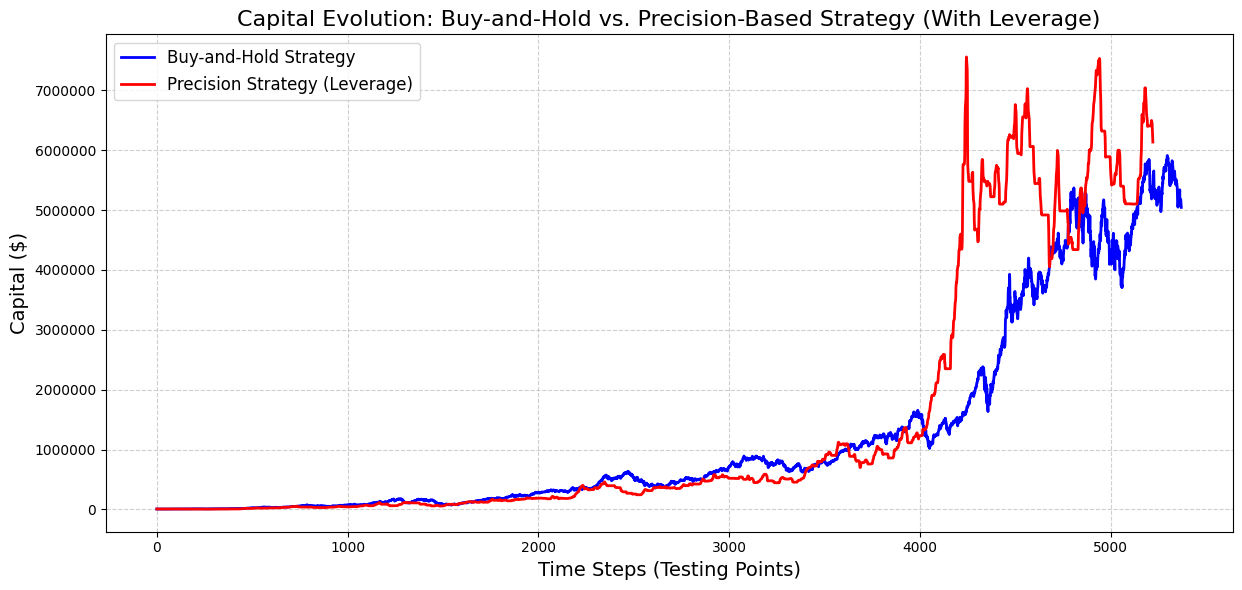

In [41]:
buy_and_hold = [7000]
for i in range(731, 6100):
    buy_and_hold.append(7000*((data_df["Close"][i] / data_df["Close"][730])))
buy_and_hold = np.array(buy_and_hold)

plt.figure(figsize=(12, 6))
plt.plot(buy_and_hold, label='Buy-and-Hold Strategy', linewidth=2, color='blue')
plt.plot(weekly_capital_leverage, label='Precision Strategy (Leverage)', linewidth=2, color='red')

plt.title('Capital Evolution: Buy-and-Hold vs. Precision-Based Strategy (With Leverage)', fontsize=16)
plt.xlabel('Time Steps (Testing Points)', fontsize=14)
plt.ylabel('Capital ($)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.ticklabel_format(style='plain', axis='y')  
plt.show()

## Discussion

In this section, we present the code used for the Discussion section.

### No Filtration of Trades

The following plot is a result of the simulation that follows the same procedure but does not filter the trading opportunities using $$p_{val} > p_{min}$$

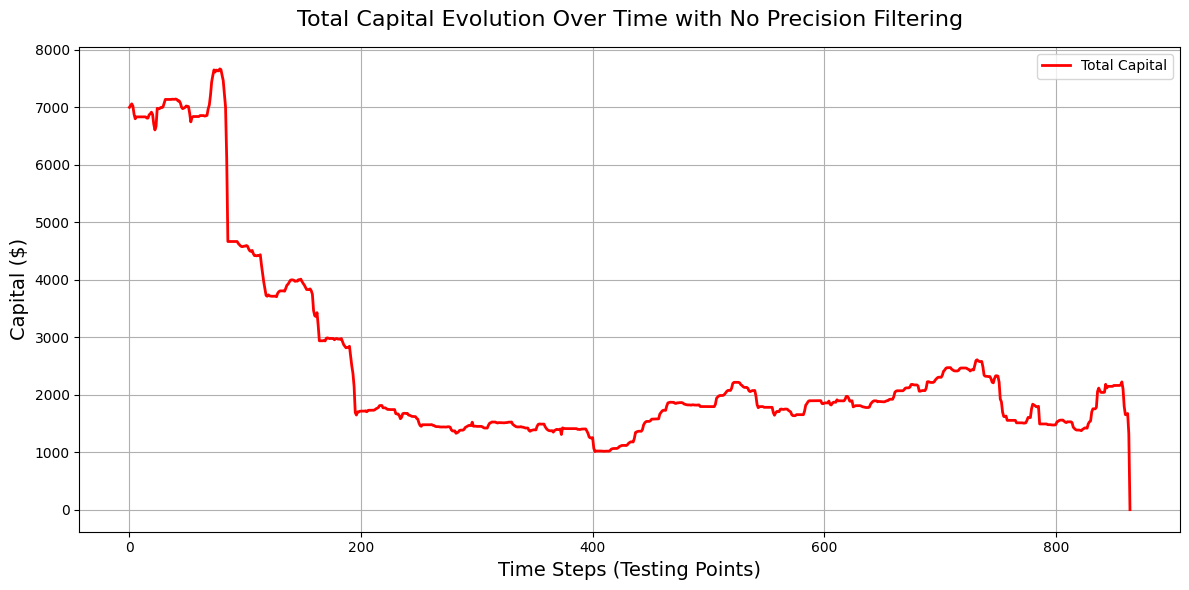

In [42]:
number_of_trades = 0
initial_capitals = [1000 for i in range(7)]
capital_evolutions = [[1000] for i in range(7)]
movement_pred = list_test_pred
returns = list_test_returns
tracker = 0

for i in range(len(movement_pred)):
    for j in range(len(movement_pred[i])):
        if optimal_fractions[i][j] > 1:
            f = 1
        else:
            f = optimal_fractions[i][j]
        corresponding_returns = list(returns[i][j])

        for z in range(len(movement_pred[i][j])):
            if movement_pred[i][j][z] == 1:
                number_of_trades += 1
                
                initial_capitals[tracker % 7] += (initial_capitals[tracker % 7] * f) * corresponding_returns[z] 
                capital_evolutions[tracker  % 7].append(initial_capitals[tracker  % 7])
                
            else:
                capital_evolutions[tracker  % 7].append(initial_capitals[tracker  % 7])
            
            for k in range(len(capital_evolutions)):
                if k != tracker % 7:
                    capital_evolutions[k].append(initial_capitals[k])
            tracker += 1

for i in range(len(capital_evolutions)): 
    capital_evolutions[i] = np.array(capital_evolutions[i])
capital_evolutions = np.array(capital_evolutions)

weekly_capital = np.sum(capital_evolutions, axis=0)

plt.figure(figsize=(12, 6))
zero_idx = np.argmax(weekly_capital <= 0)
weekly_capital[zero_idx] = 0
if weekly_capital[zero_idx] > 0:
    zero_idx = len(weekly_capital)  # No zero found, plot all

plt.plot(weekly_capital[:zero_idx+1], label='Total Capital', color='red', linewidth=2)
plt.title('Total Capital Evolution Over Time with No Precision Filtering', fontsize=16, pad=15)
plt.xlabel('Time Steps (Testing Points)', fontsize=14)
plt.ylabel('Capital ($)', fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Look-ahead Bias

we modify the validation setup by selecting a portion of the test points and, instead of assigning the test point 7 trading days after the validation window, we use the immediate subsequent day. This setup allows us to simulate a scenario where future information slightly leaks into the decision-making process. This section demonstrates that, if we can accurately estimate precision and, consequently, determine an effective threshold for predicting positive movements, strong results can still be achieved, even without using leverage. The following chunk of code have the same chunks of codes used previously to calculate the optimal fractions, validation precisions, and expected returns.

In [43]:
list_validation_sets = []
list_test_sets = []
list_y_test = []
list_y_validation = []
list_test_returns = []
list_val_returns = []

max_val_size = 30
prediction_horizon = 0
for i in range(len(models_predictions)):
    test_size = 1
    start_validation_size = 30
    validation_sets = []
    test_sets = []
    val_return_sets = []
    test_return_sets = []
    y_true_test = []
    y_true_val = []
    
    while start_validation_size + prediction_horizon < 365:
        if 365 - start_validation_size < test_size:
            test_size = 365 - start_validation_size
        
        low_bound = start_validation_size - max_val_size * int(start_validation_size >= max_val_size)
        
        validation_sets.append(models_predictions[i][low_bound : start_validation_size])
        y_true_val.append(y_test_sets[i][low_bound : start_validation_size])
        val_return_sets.append(daily_returns_set[i][low_bound: start_validation_size])

        test_sets.append(models_predictions[i][start_validation_size + prediction_horizon : start_validation_size + test_size + prediction_horizon])
        y_true_test.append(y_test_sets[i][start_validation_size + prediction_horizon : start_validation_size + test_size + prediction_horizon])
        test_return_sets.append(daily_returns_set[i].values[start_validation_size + prediction_horizon : start_validation_size + test_size + prediction_horizon])

       
        start_validation_size += test_size
        
    
    list_validation_sets.append(validation_sets)
    list_test_sets.append(test_sets)
    list_y_test.append(y_true_test)
    list_y_validation.append(y_true_val)
    list_test_returns.append(test_return_sets)
    list_val_returns.append(val_return_sets)

list_best_thresholds = []
list_best_precisions = []
list_num_predictions = []
for i in range(len(list_validation_sets)):
    best_thresholds = []
    best_precisions = []
    best_num_positives = []

    for j in range(len(list_validation_sets[i])):
        precisions = [None for i in range(101)]
        positives_predicted = [None for i in range(101)]
        for p in range(101):
            y_preds = (list_validation_sets[i][j] > p/100).astype("int32")
            positives = len(y_preds[y_preds == 1])
            precision = precision_score(list_y_validation[i][j], y_preds)
            precisions[p] = precision
            positives_predicted[p] = positives
        
        maximum_precision = 0
        corresponding_pos = 0
        index = 0
        for p in range(101):
            if precisions[p] > maximum_precision and positives_predicted[p] >= len(list_validation_sets[i][j]) * (70/100):
                maximum_precision = precisions[p]
                corresponding_pos = positives_predicted[p]
                index = p

        best_thresholds.append(index)
        best_precisions.append(maximum_precision)
        best_num_positives.append(corresponding_pos)
    
    list_best_thresholds.append(best_thresholds)
    list_best_precisions.append(best_precisions)
    list_num_predictions.append(best_num_positives)

list_test_pred = []
for i in range(len(list_test_sets)):
    years_preds = []
    for j in range(len(list_test_sets[i])):
        y_preds = (list_test_sets[i][j] > list_best_thresholds[i][j]/100).astype("int32")
        years_preds.append(y_preds)
    list_test_pred.append(years_preds)

expectations_Xi = []

for i in range(len(list_test_pred)):
    window_expectations_Xi = []
    for j in range(len(list_test_pred[i])):
        expectation_Xi =  array_expected_pos_returns[i] * list_best_precisions[i][j] + array_expected_neg_returns[i] * (1 - list_best_precisions[i][j])
        window_expectations_Xi.append(expectation_Xi)
    expectations_Xi.append(window_expectations_Xi)

expectations_Xi = np.array(expectations_Xi)

sq_pos_mus = []
sq_neg_mus = []
sq_pos_sigmas = []
sq_neg_sigmas = []
for i in range(len(min_precision_thresholds)):
    sq_positive_daily_returns = list_positive_returns[i] ** 2
    sq_negative_daily_returns = list_negative_returns[i] ** 2

    # meand and standard deviation of the squarred positive returns 
    sq_pos_mu, sq_pos_sigma = stats.norm.fit(sq_positive_daily_returns)
    sq_pos_mus.append(sq_pos_mu)
    sq_pos_sigmas.append(sq_pos_sigma)

    # meand and standard deviation of the squarred positive returns 
    sq_neg_mu, sq_neg_sigma = stats.norm.fit(sq_negative_daily_returns)
    sq_neg_mus.append(sq_neg_mu)
    sq_neg_sigmas.append(sq_neg_sigma)

optimal_fractions = []
for i in range(len(list_test_pred)):
    window_optimal_fractions = []
    for j in range(len(list_test_pred[i])):
        optimal_fraction = expectations_Xi[i][j] / (list_best_precisions[i][j] * sq_pos_mus[i] + (1 - list_best_precisions[i][j]) * sq_neg_mus[i])
        window_optimal_fractions.append(optimal_fraction)
    optimal_fractions.append(window_optimal_fractions)

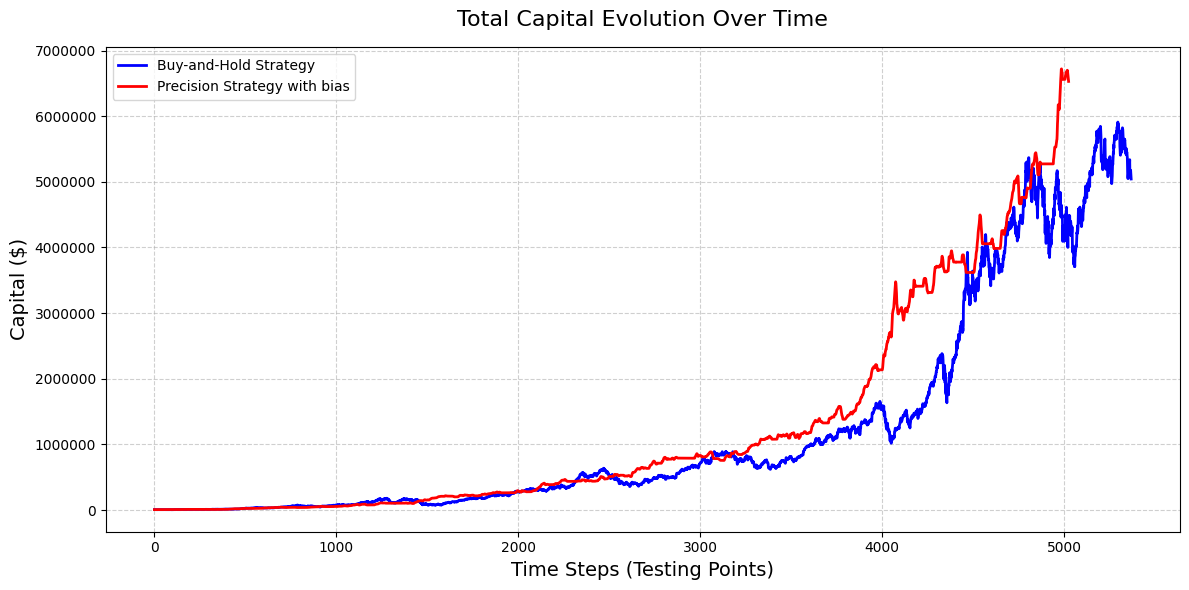

In [44]:
number_of_trades = 0
initial_capitals = [1000 for i in range(7)]
capital_evolutions = [[1000] for i in range(7)]
movement_pred = list_test_pred
returns = list_test_returns
tracker = 0

for i in range(len(movement_pred)):
    for j in range(len(movement_pred[i])):
        if list_best_precisions[i][j] > min_precision_thresholds[i]:
            if optimal_fractions[i][j] > 1:
                f = 1
            else:
                f = optimal_fractions[i][j]
            corresponding_returns = list(returns[i][j])

            for z in range(len(movement_pred[i][j])):
                if movement_pred[i][j][z] == 1:
                    number_of_trades += 1
                    
                    initial_capitals[tracker % 7] += (initial_capitals[tracker % 7] * f) * corresponding_returns[z] 
                    capital_evolutions[tracker  % 7].append(initial_capitals[tracker  % 7])
                    
                else:
                    capital_evolutions[tracker  % 7].append(initial_capitals[tracker  % 7])
                
                for k in range(len(capital_evolutions)):
                    if k != tracker % 7:
                        capital_evolutions[k].append(initial_capitals[k])
                tracker += 1
        else:
            for v in range(len(capital_evolutions)):
                capital_evolutions[v].append(initial_capitals[v])

for i in range(len(capital_evolutions)): 
    capital_evolutions[i] = np.array(capital_evolutions[i])
capital_evolutions = np.array(capital_evolutions)

weekly_capital_biased = np.sum(capital_evolutions, axis=0)

plt.figure(figsize=(12, 6))
plt.plot(buy_and_hold, label='Buy-and-Hold Strategy', linewidth=2, color='blue')
plt.plot(weekly_capital_biased, label='Precision Strategy with bias', linewidth=2, color='red')
plt.title('Total Capital Evolution Over Time', fontsize=16, pad=15)
plt.xlabel('Time Steps (Testing Points)', fontsize=14)
plt.ylabel('Capital ($)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

### Comparison Using a different Stock (Boeing Co)

The plot presented in the thesis is the result of executing all preceding code sections related to data engineering, data handling and model training, and game simulation up until the case where we use the precision-guided Kelly Strategy with leverage.

To reproduce the exact plot shown in the thesis, it is recommended to use the precomputed predictions saved in the file model_prediction_BA.pkl.

This ensures consistency, as retraining the model, due to the stochastic nature of the Random Forest algorithm, may yield slightly different results.